Device: cuda | RUNS=8 | EPOCHS=24 | SNAP=3

=== training run 1/8 (device=cuda) ===
    epoch 1/24 done in 9.4s
    epoch 6/24 done in 46.4s
    epoch 12/24 done in 55.7s
    epoch 18/24 done in 55.5s
    epoch 24/24 done in 55.7s

=== training run 2/8 (device=cuda) ===
    epoch 1/24 done in 9.3s
    epoch 6/24 done in 46.1s
    epoch 12/24 done in 55.0s
    epoch 18/24 done in 54.6s
    epoch 24/24 done in 54.6s

=== training run 3/8 (device=cuda) ===
    epoch 1/24 done in 9.1s
    epoch 6/24 done in 45.5s
    epoch 12/24 done in 54.6s
    epoch 18/24 done in 54.6s
    epoch 24/24 done in 54.5s

=== training run 4/8 (device=cuda) ===
    epoch 1/24 done in 9.1s
    epoch 6/24 done in 45.4s
    epoch 12/24 done in 54.4s
    epoch 18/24 done in 54.2s
    epoch 24/24 done in 54.2s

=== training run 5/8 (device=cuda) ===
    epoch 1/24 done in 9.1s
    epoch 6/24 done in 45.3s
    epoch 12/24 done in 54.2s
    epoch 18/24 done in 54.0s
    epoch 24/24 done in 54.1s

=== training run 6/8 

/local_scratch/slurm.5419392/ipykernel_2626541/3856908872.py:148: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', T_snap)


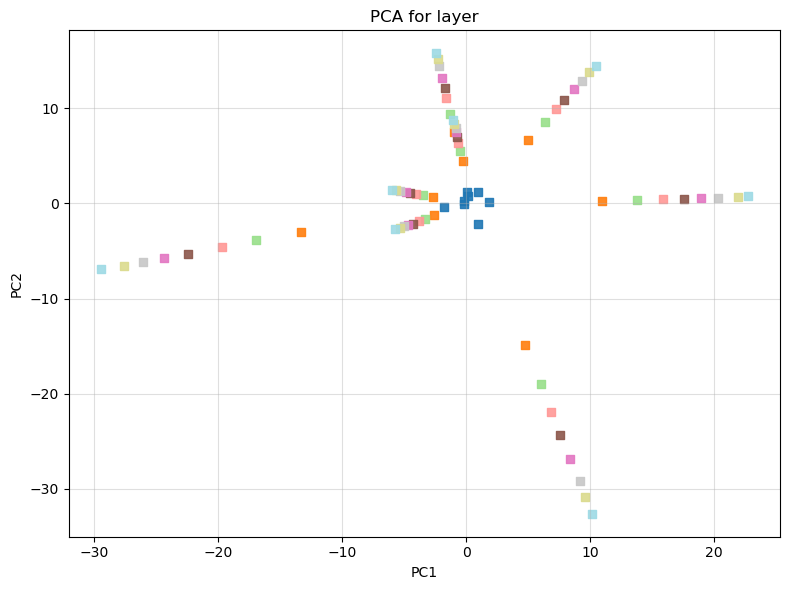

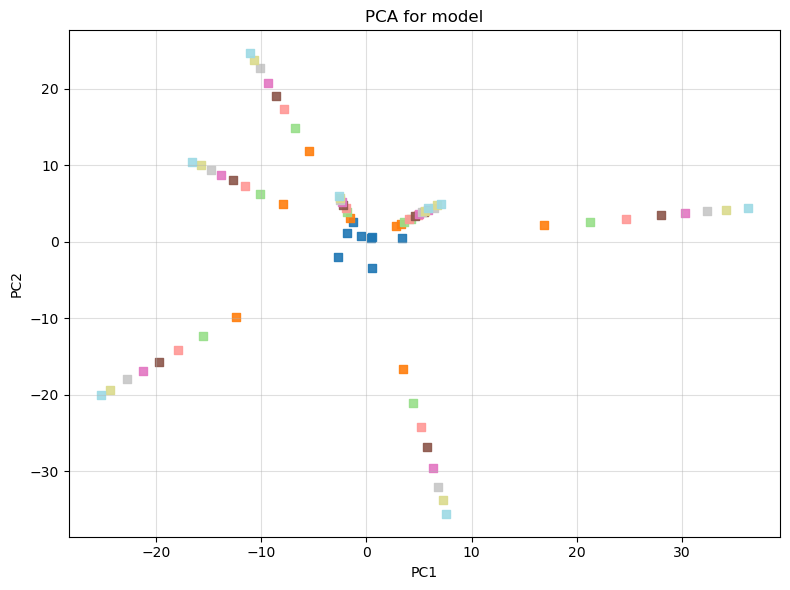

Done in 1753.8s | Also saved PNGs in 'results/'


In [1]:
import os, time, random, numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T
SEED = 1337
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTDIR = "results"
os.makedirs(OUTDIR, exist_ok=True)
SHOW_IN_NOTEBOOK = True
RUNS   = 8
EPOCHS = 24
SNAP   = 3
BATCH  = 128
LR, MOMENTUM, WD = 0.1, 0.9, 0.0
LAYER_INDEX = 0  # 0=fc1, 1=fc2, 2=fc3
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def pca_fit_transform(X, n_components=2):
    X = np.asarray(X, dtype=np.float64)
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    Z = U[:, :n_components] * S[:n_components]
    P = Vt[:n_components, :]
    return Z, (mu, P)
def pca_transform(X, fitted):
    mu, P = fitted
    return (np.asarray(X, dtype=np.float64) - mu) @ P.T
def mnist_loaders():
    tfm = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])
    train = datasets.MNIST("./data", train=True,  download=True, transform=tfm)
    test  = datasets.MNIST("./data", train=False, download=True, transform=tfm)

    
    train_loader = DataLoader(train, batch_size=BATCH, shuffle=True,
                              num_workers=0, pin_memory=False, persistent_workers=False)
    test_loader  = DataLoader(test, batch_size=512, shuffle=False,
                              num_workers=0, pin_memory=False, persistent_workers=False)
    return train_loader, test_loader
class SmallMLP(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.fc3(x)
    def layers_as_list(self):
        return [self.fc1, self.fc2, self.fc3]
@torch.no_grad()
def flat_layer(layer: nn.Linear):
    return torch.cat([layer.weight.view(-1), layer.bias.view(-1)]).cpu().numpy()

@torch.no_grad()
def flat_model(model: nn.Module):
    return torch.cat([p.view(-1).cpu() for p in model.parameters()]).numpy()

def train_once_collect():
    train_loader, _ = mnist_loaders()
    model = SmallMLP().to(DEVICE)
    opt = SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WD)
    loss_fn = nn.CrossEntropyLoss()

    layer_snaps, whole_snaps, marks = [], [], []

    def snap(ep):
        layer = model.layers_as_list()[LAYER_INDEX]
        layer_snaps.append(flat_layer(layer))
        whole_snaps.append(flat_model(model))
        marks.append(ep)

    snap(0)  
    t_last = time.perf_counter()
    for ep in range(1, EPOCHS + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            loss = loss_fn(model(xb), yb)
            loss.backward(); opt.step()

        if ep % SNAP == 0:
            snap(ep)

        
        if ep == 1 or ep % 6 == 0 or ep == EPOCHS:
            now = time.perf_counter()
            print(f"    epoch {ep}/{EPOCHS} done in {now - t_last:.1f}s")
            t_last = now

    return np.stack(layer_snaps), np.stack(whole_snaps), np.array(marks, dtype=int)
def collect_runs():
    L_runs, W_runs, M_runs = [], [], []
    for r in range(RUNS):
        print(f"\n=== training run {r+1}/{RUNS} (device={DEVICE}) ===")
        torch.manual_seed(SEED + r + 1); np.random.seed(SEED + r + 1); random.seed(SEED + r + 1)
        l, w, m = train_once_collect()
        L_runs.append(l); W_runs.append(w); M_runs.append(m)
    print("All runs finished.")
    return L_runs, W_runs, M_runs

def plot_scatter(z_runs, marks_runs, title, path, color_by="epoch", show=True):
    
    plt.figure(figsize=(8, 6))
    if color_by == "epoch":
        T_snap = z_runs[0].shape[0]
        cmap = plt.cm.get_cmap('tab20', T_snap)
        for t in range(T_snap):
            xs = [Z[t, 0] for Z in z_runs]
            ys = [Z[t, 1] for Z in z_runs]
            plt.scatter(xs, ys, s=40, marker='s', alpha=0.9, color=cmap(t))
    else:
        cmap = plt.cm.get_cmap('tab10', len(z_runs))
        for i, Z in enumerate(z_runs):
            plt.scatter(Z[:, 0], Z[:, 1], s=40, marker='s', alpha=0.9, color=cmap(i))

    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    if show:
        plt.show()
    plt.close()

if __name__ == "__main__":
    
    t0 = time.time()
    print(f"Device: {DEVICE} | RUNS={RUNS} | EPOCHS={EPOCHS} | SNAP={SNAP}")

    layer_runs, whole_runs, marks_runs = collect_runs()

    
    layer_all = np.concatenate(layer_runs, axis=0)
    whole_all = np.concatenate(whole_runs, axis=0)

    layer_Z_all, layer_fit = pca_fit_transform(layer_all, n_components=2)
    whole_Z_all, whole_fit = pca_fit_transform(whole_all, n_components=2)

    T_snap = layer_runs[0].shape[0]
    layer_Z_per = [layer_Z_all[i*T_snap:(i+1)*T_snap] for i in range(len(layer_runs))]
    whole_Z_per = [whole_Z_all[i*T_snap:(i+1)*T_snap] for i in range(len(whole_runs))]

    
    plot_scatter(
        layer_Z_per, marks_runs,
        title="PCA for layer",
        path=os.path.join(OUTDIR, f"pca_layer_{LAYER_INDEX+1}.png"),
        color_by="epoch",
        show=SHOW_IN_NOTEBOOK
    )
    plot_scatter(
        whole_Z_per, marks_runs,
        title="PCA for model",
        path=os.path.join(OUTDIR, "pca_whole_model.png"),
        color_by="epoch",
        show=SHOW_IN_NOTEBOOK
    )

    print(f"Done in {time.time()-t0:.1f}s | Also saved PNGs in '{OUTDIR}/'")
